In [11]:
from collections import Counter

import numpy as np
import collections
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from collections import OrderedDict 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

In [12]:
movie_df = pd.read_csv(r'data/data_analysis.csv')

In [13]:
print(movie_df.columns.T)

Index(['imdb_id', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'num_user_for_reviews',
       'language', 'country', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes'],
      dtype='object')


# Feature Engineering and pre-data processing
- One Hot encoding:
    - Genres
- Rating
    - Director
    - Actors: actor 1, actor 2, actor 3

## Genre

In [14]:
mlb = MultiLabelBinarizer()
genres = movie_df.genres.str.split("|")
encoded_genres = pd.DataFrame(mlb.fit_transform(genres), columns=mlb.classes_, index=movie_df.index)
encoded_genres

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3874,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3875,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3876,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


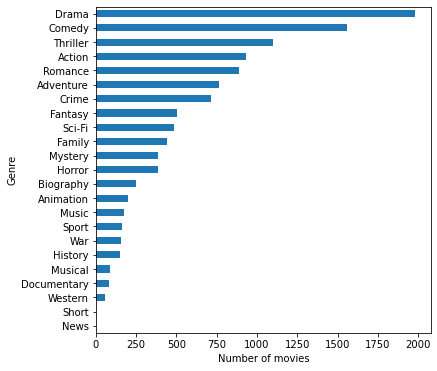

In [15]:
count_encoded_genres = encoded_genres.sum().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,6))
count_encoded_genres.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Genre')
plt.show()

We can group togheter similar genres, in order to decrease the number of columns

In [16]:
# Mystery|Thriller|Horror
sum_gen = encoded_genres[['Mystery','Thriller','Horror']].sum(axis=1)
encoded_genres['Mystery_Thriller_Horror'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Mystery','Thriller','Horror'], axis=1) #drop other

#Sci-Fi|Fantasy
sum_gen = encoded_genres[['Sci-Fi','Fantasy']].sum(axis=1)
encoded_genres['Sci-Fi_Fantasy'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Sci-Fi','Fantasy'], axis=1) #drop other

#Family|Animation
sum_gen = encoded_genres[['Family','Animation']].sum(axis=1)
encoded_genres['Family_Animation'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Family','Animation'], axis=1) #drop other

#Action|Adventure
sum_gen = encoded_genres[['Action','Adventure']].sum(axis=1)
encoded_genres['Action_Adventure'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Action','Adventure'], axis=1) #drop other

#History|War
sum_gen = encoded_genres[['History','War']].sum(axis=1)
encoded_genres['History_War'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['History','War'], axis=1) #drop other


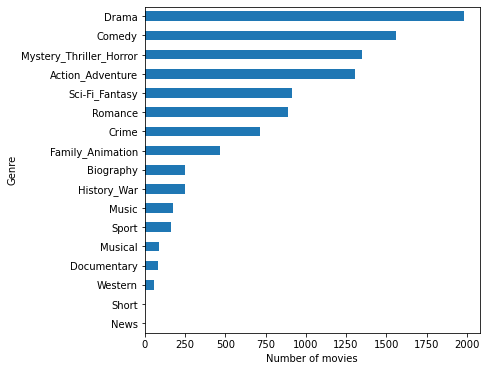

In [17]:
count_encoded_genres = encoded_genres.sum().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,6))
count_encoded_genres.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Genre')
plt.show()

At this point we can put togheter genres which are not common:

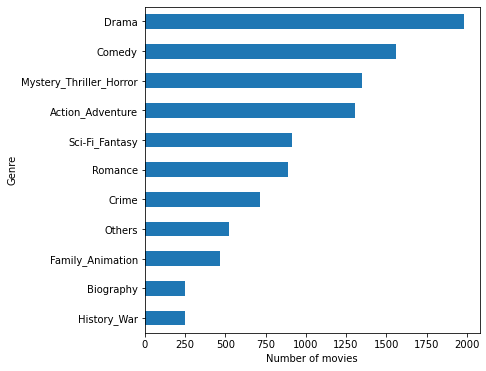

In [18]:
#Other
other = ['Music','Sport','Documentary','Musical','Western','Short','News']

sum_gen = encoded_genres[other].sum(axis=1)
encoded_genres['Others'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(other, axis=1) #drop other

# Add genres columns to movie_df
movie_df = movie_df.merge(encoded_genres,how='left', left_index=True, right_index=True)

count_encoded_genres = encoded_genres.sum().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,6))
count_encoded_genres.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Genre')
plt.show()

## Director

In [19]:
group_director = movie_df.groupby('director_name') # group the database for the director
directors = list(movie_df.director_name.values) #director list
directors_unique =list(OrderedDict.fromkeys(directors)) # no duplicates

#number of movies for each director
#counter = collections.Counter(directors)
results = [directors.count(x) for x in directors_unique] #number of films
directors = pd.DataFrame([directors_unique, results], index=['director', 'num_movies']).T
directors = directors.set_index('director')
directors.head()

,num_movies
director,
James Mangold,8
Jim Abrahams,1
Randal Kleiser,2
John Landis,3
Harold Ramis,8


In the regression, we cannot use variables which are consequnces, as movie_facebook_likes. However, we can use them to understand how much a director is famous. If a film has a lot of likes, its director will probably earn a good reputation.

Same reasoning for imdb_score

In [20]:
# mean movie_facebook_likes for the movies did by that director
num_likes = group_director.mean().movie_facebook_likes
directors = directors.merge(num_likes,how='left', left_index=True, right_index=True)

# mean movie_facebook_likes for the movies did by that director
score = group_director.mean().imdb_score
directors = directors.merge(score, how='left', left_index=True, right_index=True)

directors.head(10)

,num_movies,movie_facebook_likes,imdb_score
director,,,
James Mangold,8,12875.000000,7.075000
Jim Abrahams,1,16000.000000,7.800000
Randal Kleiser,2,0.000000,6.200000
John Landis,3,4889.666667,6.966667
Harold Ramis,8,4855.750000,6.550000
Nancy Walker,1,1000.000000,4.500000
Michael Apted,6,4392.000000,6.516667
Brian De Palma,10,2165.500000,6.600000
David Lynch,4,9000.000000,7.700000


Director:


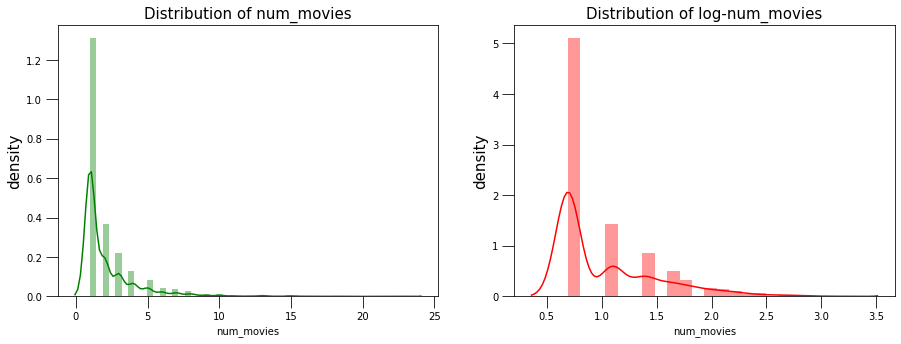

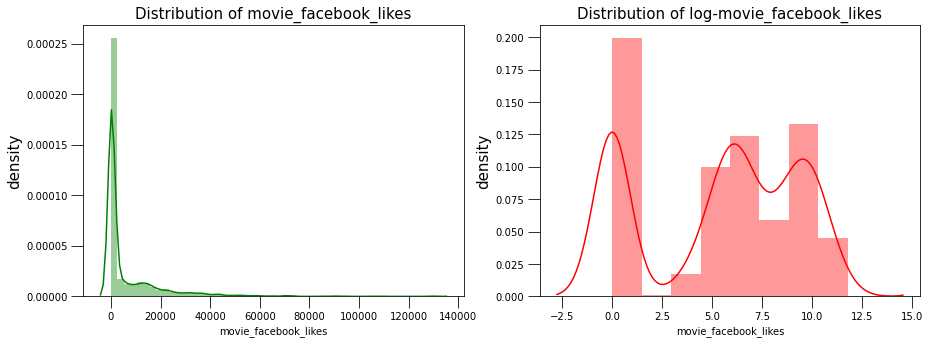

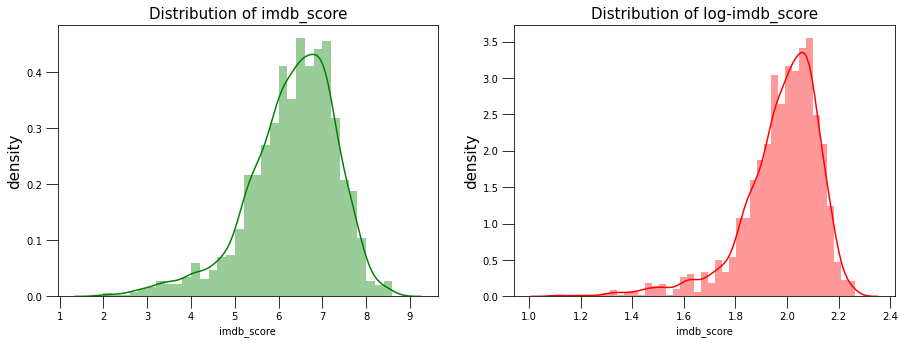

In [21]:
print("Director:")
for col in ["num_movies", "movie_facebook_likes", "imdb_score"]:
    _, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    sns.distplot(directors[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(directors[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

Using these three features, we can create a ranking for the directors. We consider 10 levels. If a director is in level 10, he is really important: he has done a lot of movies with high ranking. 

In order to do that, we 
- trasform this variables in values between 0 and 1
- do the mean of each column (same weight for each feature)
- create 10 groups

In [22]:
#we divide wach value for the max of that column in order to have values between 0 and 1
directors.num_movies = directors.num_movies/directors.num_movies.max()

# log for likes 
max_likes = np.log(directors.movie_facebook_likes.max())
directors.movie_facebook_likes = [1 if x == 0 else x for x in directors.movie_facebook_likes.values] # edit zeros to use log
directors.movie_facebook_likes = directors.movie_facebook_likes/max_likes
directors.imdb_score = directors.imdb_score/directors.imdb_score.max()

#we consider that each column has the same weight and we do the mean 
directors['mean_'] = directors.num_movies*1/3 + directors.movie_facebook_likes*1/3 + directors.imdb_score*1/3
massimo = directors.mean_.max()
directors['director_rank'] = [int(x) for x in directors.mean_/massimo*10]

directors = directors.sort_values(['director_rank','num_movies'], ascending=False)

directors.head(10)

,num_movies,movie_facebook_likes,imdb_score,mean_,director_rank
director,,,,,
Stephen Chbosky,0.0434783,11117.756680,0.930233,3706.24,10
Damien Chazelle,0.0434783,10948.019937,0.988372,3649.68,9
Alex Garland,0.0434783,9250.652505,0.895349,3083.86,8
Tim Miller,0.0434783,9929.599477,0.941860,3310.19,8
Christopher Nolan,0.347826,8794.485007,0.979651,2931.94,7
Morten Tyldum,0.0869565,7977.626931,0.912791,2659.54,7
Josh Boone,0.0434783,7892.758559,0.906977,2631.24,7
Joss Whedon,0.130435,7213.811586,0.914729,2404.95,6
Colin Trevorrow,0.0869565,7680.587630,0.813953,2560.5,6


In [23]:
# merge two dataset togheter
movie_df = pd.merge(left=movie_df, right=directors.director_rank, left_on='director_name', right_on='director')

### Actors
- Actor1
- Actor2
- Actor3

w do not want to use directly the column of actors_facebook_likes because we would like also to consider how many films they have done. 

**Actor 1**

In [24]:
# actor_1_name
actor1 = movie_df.groupby('actor_1_name') # group the database for the actor_1_name
actors1 = list(movie_df.actor_1_name.values) #director list
actors1_unique =list(OrderedDict.fromkeys(actors1)) # no duplicates

#number of movies for each actor1
results = [actors1.count(x) for x in actors1_unique] #number of films
actors1 = pd.DataFrame([actors1_unique, results], index=['actors1', 'num_movies']).T
actors1 = actors1.set_index('actors1')

# mean actor_1_facebook_likes for the movies did by that director
num_likes = actor1.mean().actor_1_facebook_likes
actors1 = actors1.merge(num_likes, how='left', left_index=True, right_index=True)

actors1.head(5)

,num_movies,actor_1_facebook_likes
actors1,,
Hugh Jackman,18,20000.0
Robert De Niro,41,22000.0
Angelina Jolie Pitt,15,11000.0
Clea DuVall,2,1000.0
Sandra Ellis Lafferty,1,523.0


Actor1:


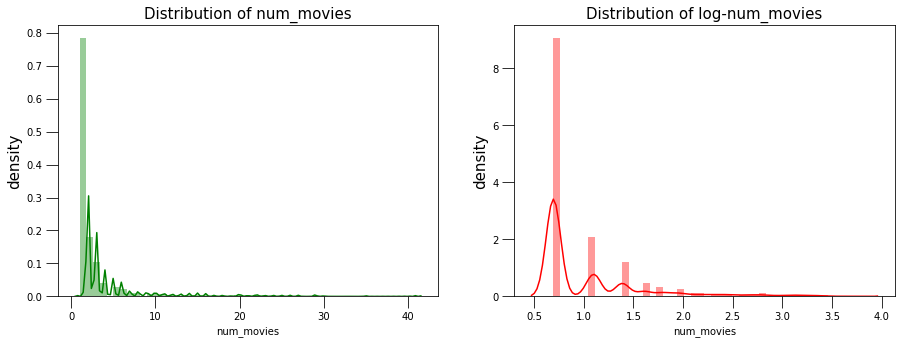

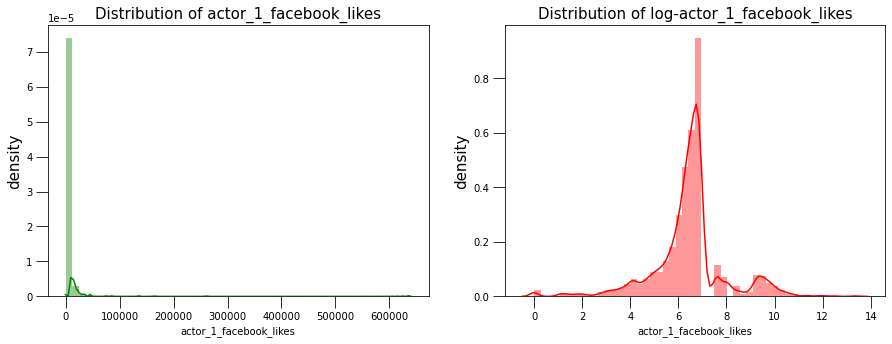

In [25]:
print("Actor1:")
for col in ["num_movies", "actor_1_facebook_likes"]:
    _, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    sns.distplot(actors1[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(actors1[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

In [26]:
#we divide wach value for the max of that column in order to have values between 0 and 1
actors1.num_movies = actors1.num_movies/actors1.num_movies.max()
# log for facebook likes
max_likes = np.log(actors1.actor_1_facebook_likes.max())
actors1.actor_1_facebook_likes = [1 if x == 0 else x for x in actors1.actor_1_facebook_likes.values] # edit zeros to use log
actors1.actor_1_facebook_likes = np.log(actors1.actor_1_facebook_likes)/max_likes

#we consider that each column has the same weight and we do the mean 
actors1['mean_'] = actors1.num_movies*1/2 + actors1.actor_1_facebook_likes*1/2
massimo = actors1.mean_.max()
actors1['actor1_rank'] = [int(x) for x in actors1.mean_/massimo*10]

actors1 = actors1.sort_values(['actor1_rank','num_movies'], ascending=False)

# add row for no actor
#actors1 = actors1.append(fill, ignore_index=False, verify_integrity=False, sort=None)
df2 = pd.DataFrame([['No Actor',0,0,0,0]],columns=['actors1','num_movies','actor_1_facebook_likes','mean_','actor1_rank']).set_index('actors1')
actors1 = actors1.append(df2)

actors1.head(10)

,num_movies,actor_1_facebook_likes,mean_,actor1_rank
actors1,,,,
Robert De Niro,1,0.747897,0.873948,10
Johnny Depp,0.853659,0.792614,0.823136,9
Nicolas Cage,0.731707,0.702559,0.717133,8
J.K. Simmons,0.707317,0.754405,0.730861,8
Matt Damon,0.707317,0.708546,0.707931,8
Denzel Washington,0.707317,0.732887,0.720102,8
Robin Williams,0.658537,0.807794,0.733165,8
Bruce Willis,0.658537,0.708546,0.683541,7
Steve Buscemi,0.634146,0.702559,0.668352,7


In [27]:

actors1.head()

,num_movies,actor_1_facebook_likes,mean_,actor1_rank
actors1,,,,
Robert De Niro,1,0.747897,0.873948,10
Johnny Depp,0.853659,0.792614,0.823136,9
Nicolas Cage,0.731707,0.702559,0.717133,8
J.K. Simmons,0.707317,0.754405,0.730861,8
Matt Damon,0.707317,0.708546,0.707931,8


**Actor 2**

In [28]:
# actor_2_name
actor2 = movie_df.groupby('actor_2_name') # group the database for the actor_2_name
actors2 = list(movie_df.actor_2_name.values) #director list
actors2_unique =list(OrderedDict.fromkeys(actors2)) # no duplicates

#number of movies for each actor2
results = [actors2.count(x) for x in actors2_unique] #number of films
actors2 = pd.DataFrame([actors2_unique, results], index=['actors2', 'num_movies']).T
actors2 = actors2.set_index('actors2')

# mean actor_2_facebook_likes for the movies did by that director
num_likes = actor2.mean().actor_2_facebook_likes
actors2 = actors2.merge(num_likes,how='left', left_index=True, right_index=True)

actors2.head(5)

,num_movies,actor_2_facebook_likes
actors2,,
Natasha Lyonne,2,1000.0
Sylvester Stallone,6,13000.0
Clea DuVall,6,1000.0
Rebecca De Mornay,3,872.0
Dallas Roberts,1,405.0


Actor2:


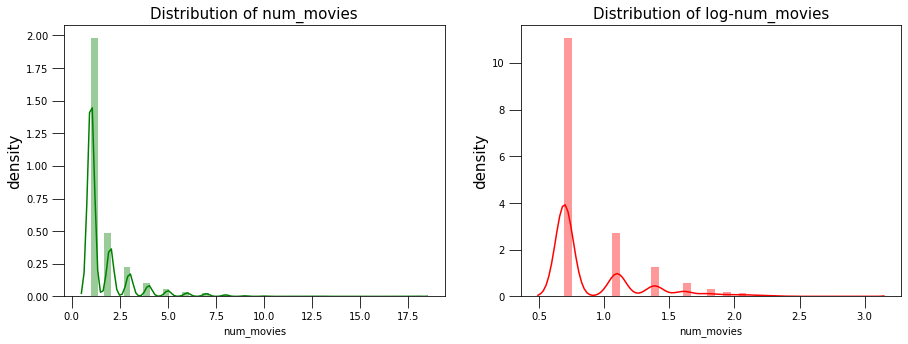

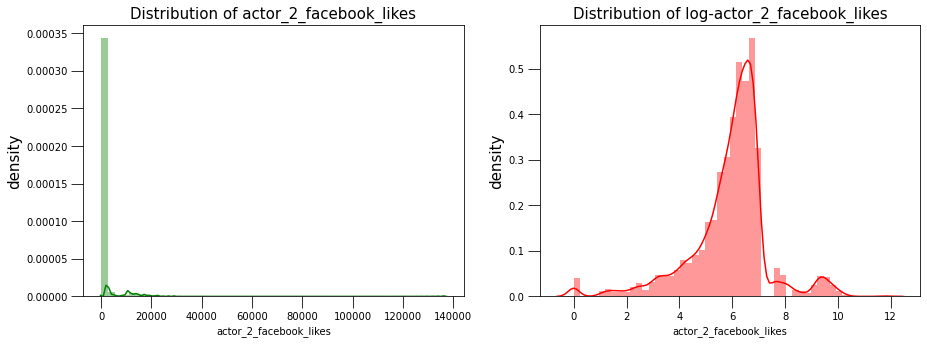

In [29]:
print("Actor2:")
for col in ["num_movies", "actor_2_facebook_likes"]:
    _, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    sns.distplot(actors2[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(actors2[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

In [30]:
#we divide wach value for the max of that column in order to have values between 0 and 1
actors2.num_movies = actors2.num_movies/actors2.num_movies.max()
# log for facebook likes
max_likes = np.log(actors2.actor_2_facebook_likes.max())
actors2.actor_2_facebook_likes = [1 if x == 0 else x for x in actors2.actor_2_facebook_likes.values] # edit zeros to use log
actors2.actor_2_facebook_likes = np.log(actors2.actor_2_facebook_likes)/max_likes

#we consider that each column has the same weight and we do the mean 
actors2['mean_'] = actors2.num_movies*1/2 + actors2.actor_2_facebook_likes*1/2
massimo = actors2.mean_.max()
actors2['actor2_rank'] = [int(x) for x in actors2.mean_/massimo*10]

actors2 = actors2.sort_values(['actor2_rank','num_movies'], ascending=False)

# add row for no actor
#actors1 = actors1.append(fill, ignore_index=False, verify_integrity=False, sort=None)
df2 = pd.DataFrame([['No Second Actor',0,0,0,0]],columns=['actors2','num_movies','actor_2_facebook_likes','mean_','actor2_rank']).set_index('actors2')
actors2 = actors2.append(df2)

actors2.head(10)

,num_movies,actor_2_facebook_likes,mean_,actor2_rank
actors2,,,,
Morgan Freeman,1,0.786765,0.893383,10
Charlize Theron,0.777778,0.769799,0.773788,8
Brad Pitt,0.722222,0.786765,0.754494,8
Meryl Streep,0.555556,0.786765,0.67116,7
James Franco,0.555556,0.786765,0.67116,7
Bruce Willis,0.5,0.800889,0.650445,7
Adam Sandler,0.5,0.786765,0.643383,7
Will Ferrell,0.5,0.759841,0.62992,7
Kate Winslet,0.444444,0.807155,0.6258,7


**Actor 3**

In [31]:
# actor_3_name
actor3 = movie_df.groupby('actor_3_name') # group the database for the actor_3_name
actors3 = list(movie_df.actor_3_name.values) #director list
actors3_unique =list(OrderedDict.fromkeys(actors3)) # no duplicates

#number of movies for each actor3
results = [actors3.count(x) for x in actors3_unique] #number of films
actors3 = pd.DataFrame([actors3_unique, results], index=['actors3', 'num_movies']).T
actors3 = actors3.set_index('actors3')

# mean actor_3_facebook_likes for the movies did by that director
num_likes = actor3.mean().actor_3_facebook_likes
actors3 = actors3.merge(num_likes,how='left', left_index=True, right_index=True)

actors3.head(5)

,num_movies,actor_3_facebook_likes
actors3,,
Bradley Whitford,1,821.0
Janeane Garofalo,1,1000.0
Vanessa Redgrave,3,898.0
Jake Busey,3,660.0
Tyler Hilton,1,154.0


Actor3:


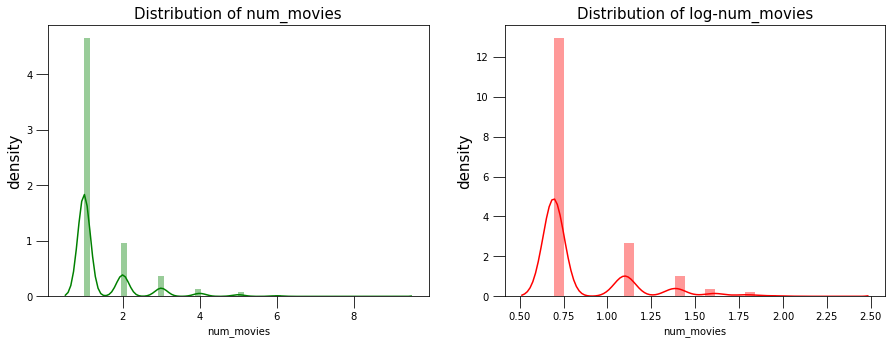

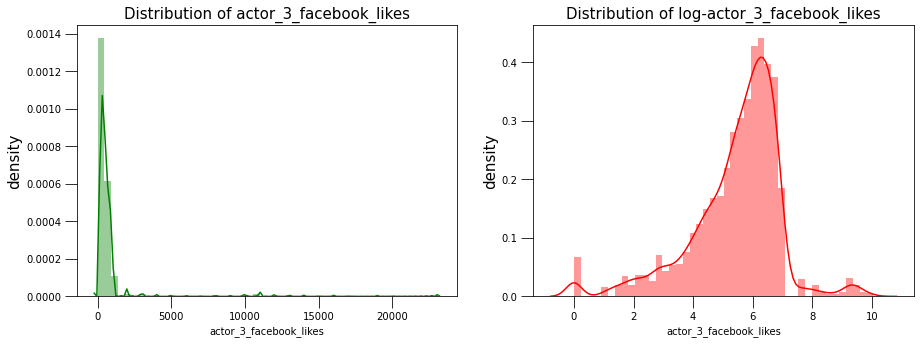

In [32]:
print("Actor3:")
for col in ["num_movies", "actor_3_facebook_likes"]:
    _, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    sns.distplot(actors3[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(actors3[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

In [33]:
#we divide wach value for the max of that column in order to have values between 0 and 1
actors3.num_movies = actors3.num_movies/actors3.num_movies.max()
# log for facebook likes
max_likes = np.log(actors3.actor_3_facebook_likes.max())
actors3.actor_3_facebook_likes = [1 if x == 0 else x for x in actors3.actor_3_facebook_likes.values] # edit zeros to use log
actors3.actor_3_facebook_likes = np.log(actors3.actor_3_facebook_likes)/max_likes

#we consider that each column has the same weight and we do the mean 
actors3['mean_'] = actors3.num_movies*1/2 + actors3.actor_3_facebook_likes*1/2
massimo = actors3.mean_.max()
actors3['actor3_rank'] = [int(x) for x in actors3.mean_/massimo*10]

actors3 = actors3.sort_values(['actor3_rank','num_movies'], ascending=False)

# add row for no actor
#actors1 = actors1.append(fill, ignore_index=False, verify_integrity=False, sort=None)
df2 = pd.DataFrame([['No Third Actor',0,0,0,0]],columns=['actors3','num_movies','actor_3_facebook_likes','mean_','actor3_rank']).set_index('actors3')
actors3 = actors3.append(df2)

actors3.head(10)

,num_movies,actor_3_facebook_likes,mean_,actor3_rank
actors3,,,,
Anne Hathaway,0.666667,0.926558,0.796612,10
Steve Coogan,0.888889,0.687801,0.788345,9
Ben Mendelsohn,0.777778,0.658891,0.718334,9
Sam Shepard,0.777778,0.668041,0.722909,9
Kirsten Dunst,0.666667,0.825833,0.74625,9
Steve Carell,0.666667,0.881554,0.77411,9
Gary Oldman,0.555556,0.917068,0.736312,9
Stephen Root,0.666667,0.681534,0.6741,8
Kevin Pollak,0.666667,0.632527,0.649597,8


Add director and actors ratings to movie_df:

In [34]:
movie_df = pd.merge(left=movie_df, right=directors.director_rank , left_on='director_name', right_on='director')
movie_df = pd.merge(left=movie_df, right=actors1.actor1_rank , left_on='actor_1_name', right_on='actors1')
movie_df = pd.merge(left=movie_df, right=actors2.actor2_rank , left_on='actor_2_name', right_on='actors2')
movie_df = pd.merge(left=movie_df, right=actors3.actor3_rank , left_on='actor_3_name', right_on='actors3')

movie_df = movie_df.sort_values(by='imdb_id').drop_duplicates(subset='imdb_id', keep='last').set_index('imdb_id')
movie_df

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others,director_rank_x,director_rank_y,actor1_rank,actor2_rank,actor3_rank
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0035423,James Mangold,125.0,123.0,446.0,821.0,Natasha Lyonne,20000.0,47095453.0,Comedy|Fantasy|Romance,Hugh Jackman,...,1,0,0,0,0,0,0,6,3,4
tt0080339,Jim Abrahams,134.0,88.0,104.0,318.0,Lloyd Bridges,628.0,83400000.0,Comedy,Peter Graves,...,0,0,0,0,0,1,1,2,3,4
tt0080453,Randal Kleiser,36.0,104.0,116.0,83.0,Christopher Atkins,1000.0,58853106.0,Adventure|Drama|Romance,Brooke Shields,...,0,0,1,0,0,0,0,3,3,3
tt0080455,John Landis,125.0,148.0,644.0,326.0,Aretha Franklin,1000.0,54200000.0,Action|Comedy|Crime|Music,John Belushi,...,0,0,1,0,1,0,0,3,3,4
tt0080487,Harold Ramis,71.0,98.0,11000.0,484.0,Rodney Dangerfield,13000.0,39800000.0,Comedy|Sport,Bill Murray,...,0,0,0,0,1,0,0,7,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt4786282,David F. Sandberg,159.0,81.0,26.0,300.0,Amiah Miller,2000.0,56536016.0,Horror,Billy Burke,...,0,0,0,0,0,0,0,3,3,4
tt4824308,Harold Cronk,29.0,120.0,18.0,295.0,Robin Givens,634.0,20773070.0,Drama,Benjamin A. Onyango,...,0,0,0,0,0,0,0,2,3,4
tt4871980,Bille Woodruff,12.0,96.0,23.0,503.0,Brandy Norwood,927.0,9658370.0,Comedy|Romance,Donald Faison,...,0,0,0,0,0,0,0,3,3,4


In [35]:
movie_df.to_csv('data/data_regression.csv')